# Physics-Informed Neural Network (PINN)

#### The key idea behind a PINN is to include the governing physics directly in the loss function, so the network's predictions obey these physical constraints.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

filtered_data = pd.read_csv('source_events_50.csv')


# Step 1: Add additional features (sin(Theta), cos(Theta), distance between planes)
def add_new_features(df):
    df['sin_Theta'] = np.sin(df['Theta'])
    df['cos_Theta'] = np.cos(df['Theta'])
    df['distance'] = np.sqrt((df['Scatter_X'] - df['Absorb_X'])**2 + (df['Scatter_Y'] - df['Absorb_Y'])**2)
    df = df.drop(columns=['Theta'])  # Drop Theta if not needed
    return df

# Assuming 'filtered_data' dataset containing Scatter_X, Scatter_Y, Absorb_X, Absorb_Y, Theta
filtered_data = add_new_features(filtered_data)

# Step 2: Prepare the data for training
X = filtered_data[['Scatter_X', 'Scatter_Y', 'Absorb_X', 'Absorb_Y', 'sin_Theta', 'cos_Theta', 'distance']]
y = filtered_data[['Source_X', 'Source_Y']]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the feature data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32)

# Step 3: Define the PINN model (feed-forward network)
class PINNModel(nn.Module):
    def __init__(self):
        super(PINNModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)  # Output for Source_X and Source_Y

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Step 4: Physics-informed loss function
def physics_informed_loss(y_pred, scatter_x, scatter_y, absorb_x, absorb_y, theta, y_true):
    mse_loss = nn.MSELoss()(y_pred, y_true)
    
    # physics constraint (distance-based)
    distance_pred = torch.sqrt((scatter_x - absorb_x)**2 + (scatter_y - absorb_y)**2)
    physics_loss = torch.mean((distance_pred - theta)**2)  
    
    total_loss = mse_loss + 0.1 * physics_loss #scaling factor 0.1 chosen arbitrarily
    return total_loss

# Step 5: R² calculation function
def r2_score(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2.item()

# Step 6: Initialize the model, optimizer, and define training parameters
model = PINNModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 7: Train the model with physics-informed loss and calculate R²
num_epochs = 200
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear previous gradients
    
    outputs = model(X_train)
    
    # Physics-informed loss
    loss = physics_informed_loss(
        outputs,
        scatter_x=X_train[:, 0],
        scatter_y=X_train[:, 1],
        absorb_x=X_train[:, 2],
        absorb_y=X_train[:, 3],
        theta=X_train[:, 4],  
        y_true=y_train
    )
    
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    
    # Calculate R² score for training data
    train_r2 = r2_score(y_train, outputs)
    
    # Print training loss and R² score every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, R²: {train_r2:.4f}')

# Step 8: Evaluate the model on the test set
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predicted = model(X_test)
    mse_test_loss = nn.MSELoss()(predicted, y_test)
    test_r2 = r2_score(y_test, predicted)
    print(f'Test Loss (MSE): {mse_test_loss.item():.4f}, Test R²: {test_r2:.4f}')


Epoch [10/200], Loss: 513.9112, R²: -2.9729
Epoch [20/200], Loss: 502.7957, R²: -2.8869
Epoch [30/200], Loss: 484.2484, R²: -2.7435
Epoch [40/200], Loss: 453.4680, R²: -2.5056
Epoch [50/200], Loss: 406.0559, R²: -2.1391
Epoch [60/200], Loss: 339.5815, R²: -1.6252
Epoch [70/200], Loss: 259.1306, R²: -1.0032
Epoch [80/200], Loss: 184.3172, R²: -0.4249
Epoch [90/200], Loss: 145.1393, R²: -0.1220
Epoch [100/200], Loss: 143.4219, R²: -0.1087
Epoch [110/200], Loss: 142.9525, R²: -0.1051
Epoch [120/200], Loss: 140.7769, R²: -0.0883
Epoch [130/200], Loss: 140.5035, R²: -0.0862
Epoch [140/200], Loss: 140.1270, R²: -0.0833
Epoch [150/200], Loss: 139.7331, R²: -0.0802
Epoch [160/200], Loss: 139.4229, R²: -0.0778
Epoch [170/200], Loss: 139.0991, R²: -0.0753
Epoch [180/200], Loss: 138.7810, R²: -0.0729
Epoch [190/200], Loss: 138.4658, R²: -0.0704
Epoch [200/200], Loss: 138.1511, R²: -0.0680
Test Loss (MSE): 138.2200, Test R²: -0.0730


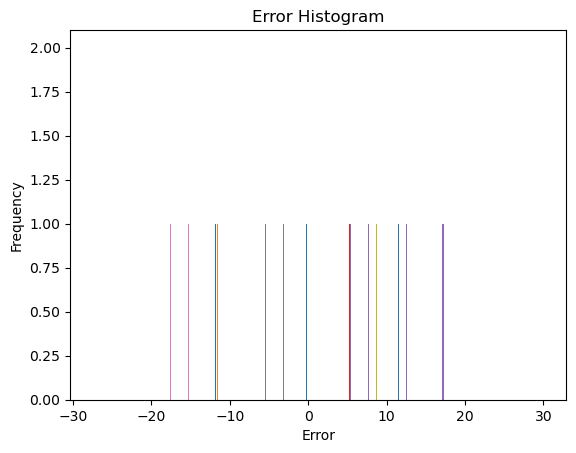

In [10]:
#plot histograms of errors between y_true and y_pred 
import matplotlib.pyplot as plt
errors = y_test - predicted
plt.hist(errors, bins=50)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Histogram')
plt.show()



# After adding more Features

- Squared Features: For non-linear interactions, adding the squared terms of the features may help the model capture complex relationships.
- Interaction Terms: Multiply pairs of features to create interaction terms that may capture relationships between the scattering and absorption planes.
- Log Transformations: For features like distance that may follow a log-normal distribution, apply logarithmic transformations.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

filtered_data = pd.read_csv('source_events_50.csv')

# Step 1: Add additional features (sin(Theta), cos(Theta), distance, interaction terms, squared terms)
def add_new_features(df):
    # Add sin(Theta) and cos(Theta)
    df['sin_Theta'] = np.sin(df['Theta'])
    df['cos_Theta'] = np.cos(df['Theta'])
    
    # Add distance between the scattering and absorption planes
    df['distance'] = np.sqrt((df['Scatter_X'] - df['Absorb_X'])**2 + (df['Scatter_Y'] - df['Absorb_Y'])**2)
    
    # Add squared terms for non-linear interactions
    df['Scatter_X_sq'] = df['Scatter_X']**2
    df['Scatter_Y_sq'] = df['Scatter_Y']**2
    df['Absorb_X_sq'] = df['Absorb_X']**2
    df['Absorb_Y_sq'] = df['Absorb_Y']**2
    
    # Add interaction terms (pairwise multiplication)
    df['Scatter_Absorb_X'] = df['Scatter_X'] * df['Absorb_X']
    df['Scatter_Absorb_Y'] = df['Scatter_Y'] * df['Absorb_Y']
    
    # Add log transformation for distance (handling zero values by adding a small constant)
    df['log_distance'] = np.log(df['distance'] + 1e-6)
    
    # Drop unnecessary columns like 'Theta'
    df = df.drop(columns=['Theta'])
    
    return df

# Assuming 'filtered_data' is your dataset containing Scatter_X, Scatter_Y, Absorb_X, Absorb_Y, Theta
filtered_data = add_new_features(filtered_data)

# Step 2: Prepare the data for training

# Define feature columns (inputs) and target columns (outputs)
X = filtered_data[['Scatter_X', 'Scatter_Y', 'Absorb_X', 'Absorb_Y', 'sin_Theta', 'cos_Theta', 'distance',
                   'Scatter_X_sq', 'Scatter_Y_sq', 'Absorb_X_sq', 'Absorb_Y_sq',
                   'Scatter_Absorb_X', 'Scatter_Absorb_Y', 'log_distance']]
y = filtered_data[['Source_X', 'Source_Y']]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the feature data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32)

# Step 3: Define the PINN model 
class PINNModel(nn.Module):
    def __init__(self):
        super(PINNModel, self).__init__()
        # Adjust input size to match new feature count
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # Output for Source_X and Source_Y

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Step 4: Physics-informed loss function
def physics_informed_loss(y_pred, scatter_x, scatter_y, absorb_x, absorb_y, theta, y_true):
    mse_loss = nn.MSELoss()(y_pred, y_true)
    
    # Example physics constraint (distance-based, replace with real constraint if necessary)
    distance_pred = torch.sqrt((scatter_x - absorb_x)**2 + (scatter_y - absorb_y)**2)
    physics_loss = torch.mean((distance_pred - theta)**2)  # Example
    
    total_loss = mse_loss + 0.1 * physics_loss
    return total_loss

# Step 5: R² calculation function
def r2_score(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2.item()

# Step 6: Initialize the model, optimizer, and define training parameters
model = PINNModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 7: Train the model with physics-informed loss and calculate R²
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear previous gradients
    
    outputs = model(X_train)
    
    # Physics-informed loss
    loss = physics_informed_loss(
        outputs,
        scatter_x=X_train[:, 0],
        scatter_y=X_train[:, 1],
        absorb_x=X_train[:, 2],
        absorb_y=X_train[:, 3],
        theta=X_train[:, 4],  # sin(Theta) or cos(Theta)
        y_true=y_train
    )
    
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    
    # Calculate R² score for training data
    train_r2 = r2_score(y_train, outputs)
    
    # Print training loss and R² score every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, R²: {train_r2:.4f}')

# Step 8: Evaluate the model on the test set
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predicted = model(X_test)
    mse_test_loss = nn.MSELoss()(predicted, y_test)
    test_r2 = r2_score(y_test, predicted)
    print(f'Test Loss (MSE): {mse_test_loss.item():.4f}, Test R²: {test_r2:.4f}')


Epoch [10/100], Loss: 513.7073, R²: -2.9713
Epoch [20/100], Loss: 491.1781, R²: -2.7971
Epoch [30/100], Loss: 449.1322, R²: -2.4721
Epoch [40/100], Loss: 377.2281, R²: -1.9162
Epoch [50/100], Loss: 274.8352, R²: -1.1246
Epoch [60/100], Loss: 176.8374, R²: -0.3671
Epoch [70/100], Loss: 149.0970, R²: -0.1526
Epoch [80/100], Loss: 151.2826, R²: -0.1695
Epoch [90/100], Loss: 144.7909, R²: -0.1193
Epoch [100/100], Loss: 143.9108, R²: -0.1125
Test Loss (MSE): 144.1522, Test R²: -0.1191


In [ ]:
import numpy as np
import pandas as pd
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


filtered_data = pd.read_csv('source_events_106.csv')


def add_new_features(df):
    df['sin_Theta'] = np.sin(df['Theta'])
    df['cos_Theta'] = np.cos(df['Theta'])
    df['distance'] = np.sqrt((df['Scatter_X'] - df['Absorb_X'])**2 + (df['Scatter_Y'] - df['Absorb_Y'])**2)
    df['Scatter_X_sq'] = df['Scatter_X']**2
    df['Scatter_Y_sq'] = df['Scatter_Y']**2
    df['Absorb_X_sq'] = df['Absorb_X']**2
    df['Absorb_Y_sq'] = df['Absorb_Y']**2
    df['Scatter_Absorb_X'] = df['Scatter_X'] * df['Absorb_X']
    df['Scatter_Absorb_Y'] = df['Scatter_Y'] * df['Absorb_Y']
    df['log_distance'] = np.log(df['distance'] + 1e-6)
    df = df.drop(columns=['Theta'])
    return df

# Assuming 'filtered_data' is your dataset containing Scatter_X, Scatter_Y, Absorb_X, Absorb_Y, Theta
filtered_data = add_new_features(filtered_data)

# Step 2: Prepare the data for training
X = filtered_data[['Scatter_X', 'Scatter_Y', 'Absorb_X', 'Absorb_Y', 'sin_Theta', 'cos_Theta', 'distance',
                   'Scatter_X_sq', 'Scatter_Y_sq', 'Absorb_X_sq', 'Absorb_Y_sq',
                   'Scatter_Absorb_X', 'Scatter_Absorb_Y', 'log_distance']]

# Target: You will now predict one target at a time, either 'Source_X' or 'Source_Y'
y_source_x = filtered_data['Source_X']
y_source_y = filtered_data['Source_Y']

# Split data into training and test sets for Source_X prediction
X_train, X_test, y_train_x, y_test_x = train_test_split(X, y_source_x, test_size=0.2, random_state=42)

# Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Run TPOT AutoML for Source_X
tpot = TPOTRegressor(generations=10, population_size=5, verbosity=2, random_state=42, n_jobs=-1)

# Fit the TPOT model on the training data
tpot.fit(X_train, y_train_x)

# Evaluate the model on the test set
print(f'Test Score for Source_X: {tpot.score(X_test, y_test_x)}')

# Step 4: Export the best pipeline for Source_X
tpot.export('tpot_best_pipeline_source_x.py')

# Repeat for Source_Y (You can also do this in a loop if needed)
X_train, X_test, y_train_y, y_test_y = train_test_split(X, y_source_y, test_size=0.2, random_state=42)

# Fit the TPOT model on the training data for Source_Y
tpot.fit(X_train, y_train_y)

# Evaluate the model on the test set for Source_Y
print(f'Test Score for Source_Y: {tpot.score(X_test, y_test_y)}')

# Export the best pipeline for Source_Y
tpot.export('tpot_best_pipeline_source_y.py')
